In [1]:
import os
from collections import OrderedDict
from typing import List, Tuple
# Silence TF warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
from flwr.common import Metrics
from flwr.server.strategy import FedAvg
from flwr.simulation import start_simulation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tensorflow", tf.__version__)

c:\Users\mohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-20 11:34:29,674	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


flwr 1.19.0
numpy 1.26.4
tensorflow 2.17.1


In [2]:
# Set some config variables
NUM_CLIENTS = 4
# Number of classes to predict in the dataset
NUM_CLASSES = 10
# Number of rounds of federated learning to run
NUM_ROUNDS = 2
# Input dataset tensor shape
INPUT_SHAPE = (28, 28, 1)
# Training batch size for gradient descent
BATCH_SIZE = 64
# Number of training epochs to run per round
EPOCHS = 5

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
# Scale the pixel intensities to be in the range [0, 1]
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# Convert class labels to one-hot encoding
y_train_onehot = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_onehot = keras.utils.to_categorical(y_test, NUM_CLASSES)
# split data for clients
x_train_splits = np.array_split(x_train, NUM_CLIENTS)
y_train_splits = np.array_split(y_train_onehot, NUM_CLIENTS)
x_test_splits = np.array_split(x_test, NUM_CLIENTS)
y_test_splits = np.array_split(y_test_onehot, NUM_CLIENTS)
data_splits = [((x, y), (xt, yt)) for (x, y, xt, yt) in zip(x_train_splits, y_train_splits, x_test_splits, y_test_splits)]


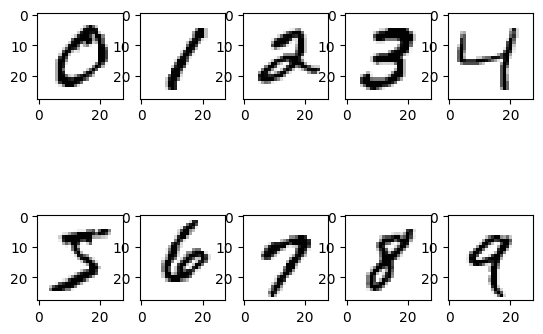

In [5]:
fig, ax = plt.subplots(2,5)
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(y_train == i)[0,0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax.imshow(plottable_image, cmap='gray_r')

In [7]:
def build_model():
    """Assemble and compile the Keras model."""
    model = keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),
            # Comment out the two Dense layers
            # and uncomment the Conv2D and MaxPooling layers layers if you want a CNN
            layers.Dense(8, activation="relu"),
            layers.Dense(4, activation="relu"),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model


model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 28, 28, 8)      │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28, 28, 4)      │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,742 (139.62 KB)

 Trainable params: 35,742 (139.62 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
(x_train_0, y_train_0), (x_test_0, y_test_0) = data_splits[0]
model.fit(x_train_0, y_train_0, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1)

Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6328 - loss: 1.1325 - val_accuracy: 0.9200 - val_loss: 0.2385
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9321 - loss: 0.2205 - val_accuracy: 0.9593 - val_loss: 0.1371
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9562 - loss: 0.1498 - val_accuracy: 0.9700 - val_loss: 0.1053
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9650 - loss: 0.1119 - val_accuracy: 0.9713 - val_loss: 0.0842
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9670 - loss: 0.0983 - val_accuracy: 0.9700 - val_loss: 0.0848


In [9]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, cid, train_data, test_data, epochs, batch_size):
        self.model = model
        self.cid = int(cid)
        self.x_train, self.y_train = train_data
        self.x_test, self.y_test = test_data
        self.epochs = epochs
        self.batch_size = batch_size

    def get_parameters(self, config):
        return self.model.get_weights()
    
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test)
        return loss, len(self.x_test), {"accuracy": float(accuracy)}

In [10]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single user device."""
    print(f"cid: {cid}")
    # Load data (MNIST)
    (x_train, y_train), (x_test, y_test) = data_splits[int(cid)]
    # Create a single Flower client representing a single device
    return FlowerClient(build_model(), cid, (x_train, y_train), (x_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

In [11]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [12]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,                                 # Proportion of clients to sample in each training round
    fraction_evaluate=0.5,                            # Proportion of clients to calculate accuracy on after each round
    min_fit_clients=10,                               # Minimum number of clients to train on in each round
    min_evaluate_clients=5,                           # Minimum number of clients to evaluate accuracy on after each round
    min_available_clients=10,                         # Minimum number of available clients needed to start a round
    evaluate_metrics_aggregation_fn=weighted_average, # <-- pass the metric aggregation function
)


In [ ]:
# Start simulation
history = start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=2, no round_timeout
2025-06-20 11:36:45,965	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'memory': 3123081216.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 1561540608.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Reso

(ClientAppActor pid=20688) cid: 1


(ClientAppActor pid=20688) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


In [1]:
history

history
